---
# M2J Parameter conversion

This notebook implements the steps required to go from Marco's pRF results to output that the line-scanning repository expects

In [1]:
from linescanning import (
    utils,
    prf,
    plotting,
    optimal
)
import pickle
import os
import shutil
import yaml
import numpy as np
opj = os.path.join

# Paths

In [2]:
# subject ID translation
sub_ma = "002"
sub_jh = "997"
sub_ve = "015"
sub_sc = "014"

# check if subject has been exluded in MA's dataset
included = [
    "002",
    "003",
    "004",
    "005",
    "010",
    "011",
    "012",
    "013",
    "015",
    "018",
    "019",
    "020"
]

# placebo sessions
ses_type = {
    "001": 1,
    "002": 2,
    "003": 3,
    "004": 2,
    "005": 1,
    "006": 3,
    "007": 3,
    "008": 1,
    "009": 2,
    "010": 1,
    "011": 3,
    "012": 2,
    "013": 3,
    "014": 2,
    "015": 2,
    # "016": 1,
    # "017": 1,
    "018": 1,
    "019": 2,
    "020": 1,
}

# placebo session for MA == session 1 for JH
ses_ma = ses_type[sub_ma]
ses_jh = 1
ses_ve = 2

# paths differ based on inclusion
ma_proj = "/data1/projects/dumoulinlab/Lab_members/Marco"
proj_dir = "/data1/projects/MicroFunc/Jurjen/projects" 
jh_proj = opj(proj_dir, "PotentialSubjs")
ve_proj = opj(proj_dir, "VE-SRF")
sc_proj = "/data1/projects/dumoulinlab/Projects/spinoza_pRF"

ma_fs = opj(ma_proj, "SM-pRF", "derivatives", "freesurfer")
if sub_ma in included:
    par_path = opj(ma_proj, "SM-pRF", "derivatives", "prfpy")
    tc_path = opj(os.path.dirname(par_path), "timecourses")
    fprep_path = opj(os.path.dirname(par_path), "fmriprep")
    par_path = opj(os.path.dirname(par_path), "prfpy")
else:
    par_path = opj(ma_proj, "legacy_SM-pRF", "excl", "excl_prfpy")
    tc_path = opj(os.path.dirname(par_path), "excl_timecourses")
    fprep_path = opj(os.path.dirname(par_path), "excl_fmriprep")
    par_path = opj(os.path.dirname(par_path), "excl_prfpy")


# fetch all files
all_pars = utils.get_file_from_substring([], par_path)
all_tcs = utils.get_file_from_substring([], tc_path)
all_pars = utils.get_file_from_substring([], par_path)

# Ingredients
- mask in fsnative space > tells us how to insert parameters into whole-brain format
- functional data
- parameters

## pRF data

In [3]:
select_ses = ses_type[sub_ma]
ses_tcs = utils.get_file_from_substring([f"sub-{sub_ma}",f"ses-{select_ses}"], all_tcs)
ses_tcs

['/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/timecourses/sub-002_ses-2_mask_space-fsnative_task-2R_run-0.npy',
 '/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/timecourses/sub-002_ses-2_mask_space-fsnative_task-2R_run-1.npy',
 '/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/timecourses/sub-002_ses-2_mask_space-fsnative_task-2R_run-2.npy',
 '/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/timecourses/sub-002_ses-2_mask_space-fsnative_task-2R_run-3.npy',
 '/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/timecourses/sub-002_ses-2_mask_space-fsnative_task-2R_run-4.npy',
 '/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/timecourses/sub-002_ses-2_mask_space-fsnative_task-2R_run-5.npy',
 '/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/timecourses/sub-002_ses-2_timecourse_space-fsnative_task-2R_run-0.npy',
 '/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivati

In [4]:
# save
prf_dir = opj(
    jh_proj,
    "derivatives",
    "prf",
    f"sub-{sub_jh}",
    "ses-1"
)

if not os.path.exists(prf_dir):
    os.makedirs(prf_dir, exist_ok=True)

# define bold
hemi_bold = opj(prf_dir, f"sub-{sub_jh}_ses-1_task-2R_hemi-LR_desc-avg_bold.npy")

if not os.path.exists(hemi_bold):
    # fetch run IDs
    run_ids = utils.get_ids(ses_tcs, bids="run")

    # loop through runs, use mask to match FreeSurfer vertices
    concat_data = []
    for run in run_ids:
        file_mask = utils.get_file_from_substring(["mask", f"run-{run}"], ses_tcs)
        file_bold = utils.get_file_from_substring(["timecourse", f"run-{run}"], ses_tcs, exclude="mask")
        
        bold_data = np.load(file_bold)
        mask_data = np.load(file_mask)

        full_data = np.zeros((mask_data.shape[0],bold_data.shape[-1]))
        full_data[mask_data>0,:] = bold_data
        concat_data.append(full_data[...,np.newaxis])

    concat_data = np.concatenate(concat_data, axis=-1).mean(axis=-1)
    print(concat_data.shape)

    print(f"Writing BOLD to {hemi_bold}")
    np.save(hemi_bold, concat_data)
else:
    print(f"Reading BOLD from {hemi_bold}")
    concat_data = np.load(hemi_bold)
    print(concat_data.shape)

Reading BOLD from /data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/sub-997_ses-1_task-2R_hemi-LR_desc-avg_bold.npy
(330956, 251)


In [5]:
# sort out design
dm_name = "dm_marco.mat" # or dm_ralph.mat
dm_ref = opj(jh_proj, "code", dm_name)
dm_trg = opj(prf_dir, "design_task-2R.mat")

if not os.path.exists(dm_trg):
    shutil.copyfile(dm_ref, dm_trg)
    os.path.exists(dm_trg)
else:
    print(f"File exists: {dm_trg}")

File exists: /data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/design_task-2R.mat


In [6]:
# fetch setting files
setting_files = utils.get_file_from_substring(["analysis","yml"], par_path)
mask_files  = utils.get_file_from_substring(["mask"], par_path)
mask_files[:5]

['/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/prfpy/sub-002_ses-1_mask_space-fsnative2023-06-28-18-00-18.npy',
 '/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/prfpy/sub-002_ses-2_mask_space-fsnative2023-10-20-14-15-28.npy',
 '/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/prfpy/sub-002_ses-3_mask_space-fsnative2023-06-28-18-00-25.npy',
 '/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/prfpy/sub-002_ses-all_mask_space-fsnative2023-06-28-21-24-09.npy',
 '/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/prfpy/sub-003_ses-1_mask_space-fsnative2023-06-28-21-47-04.npy']

In [7]:
def get_time_stamp(file):
    return "-".join(file.split("_")[-1].split("-")[2:]).split(".")[0]

In [8]:
# find model files
overwrite = False
grid_file = opj(prf_dir, f"sub-{sub_jh}_ses-{ses_jh}_task-2R_model-norm_stage-grid_desc-prf_params.pkl")
model_files = {}
for model,tag in zip(["gauss","norm"],["gauss","normabcd"]):
    search = ["iterparams", tag, "space-fsnative"]
    pars = utils.get_file_from_substring(search, all_pars)
    mask_file = utils.get_file_from_substring([f"sub-{sub_ma}",f"ses-{select_ses}"], mask_files)
    
    # copy parameters
    sub_pars = utils.get_file_from_substring([f"sub-{sub_ma}",f"ses-{select_ses}"], pars)
    if isinstance(sub_pars, list):
        sub_pars = sub_pars[-1]

    print(sub_pars)

    # match settings with timestamp in file name
    sub_settings = utils.get_file_from_substring([f"sub-{sub_ma}",f"ses-{select_ses}"], setting_files)
    if isinstance(sub_settings, list):
        t_stamp = get_time_stamp(sub_pars)
        sub_settings = utils.get_file_from_substring(t_stamp, sub_settings)

    print(sub_settings)
    with open(sub_settings, 'r', encoding='utf8') as f_in:
        settings = yaml.safe_load(f_in)

    # add vf_extent
    mask_data = np.load(mask_file)
    ppars = np.load(sub_pars)

    full_pars = np.zeros((concat_data.shape[0],ppars.shape[-1]))
    full_pars[mask_data>0] = ppars
    settings["vf_extent"] = [-5,5]
    ddict = {}
    ddict["pars"] = full_pars
    ddict["settings"] = settings

    pkl_file = opj(prf_dir, f"sub-{sub_jh}_ses-{ses_jh}_task-2R_model-{model}_stage-iter_desc-prf_params.pkl")
    
    # model-norm_stage-grid file will exists if we've refit the data already. In that case, just load the file
    if not os.path.exists(grid_file) or overwrite:
        print(f"Saving '{pkl_file}'")
        with open(pkl_file, "wb") as f:
            pickle.dump(ddict, f)
    else:
        print(f"File exists: '{pkl_file}'")

    model_files[model] = pkl_file
    print(f"{model}: '{pkl_file}'\n")

/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/prfpy/sub-002_ses-2_iterparams-gauss_space-fsnative2023-10-20-14-15-28.npy
/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/prfpy/sub-002_ses-2_analysis_settings2023-10-20-14-15-28.yml
Saving '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/sub-997_ses-1_task-2R_model-gauss_stage-iter_desc-prf_params.pkl'
gauss: '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/sub-997_ses-1_task-2R_model-gauss_stage-iter_desc-prf_params.pkl'

/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/prfpy/sub-002_ses-2_iterparams-normabcd_space-fsnative2023-10-20-14-15-28.npy
/data1/projects/dumoulinlab/Lab_members/Marco/SM-pRF/derivatives/prfpy/sub-002_ses-2_analysis_settings2023-10-20-14-15-28.yml
Saving '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/sub-997_ses-1_task-2R_model-norm_stage-iter_des

## FreeSurfer

In [9]:
fs_src = opj(ma_fs, f"sub-{sub_ma}")
fs_trg = opj(jh_proj, "derivatives", "freesurfer", f"sub-{sub_jh}")

if not os.path.exists(fs_trg):
    print(f"Copying '{fs_src}' to '{fs_trg}'")
    shutil.copytree(fs_src, fs_trg)
    print("Done")

os.path.exists(fs_trg)

True

## fMRIprep

In [10]:
fprep_src = opj(fprep_path, f"sub-{sub_ma}", f"ses-{ses_ma}")
fprep_trg = opj(jh_proj, "derivatives", "fmriprep", f"sub-{sub_jh}", f"ses-{ses_jh}")

if not os.path.exists(fprep_trg):
    os.makedirs(fprep_trg, exist_ok=True)

# decide execution rules
execute = False
if not os.path.exists(fprep_trg):
    execute = True
else:
    if len(os.listdir(fprep_trg)) == 0:
        shutil.rmtree(fprep_trg)
        execute = True

if execute:
    print(f"Copying '{fprep_src}' to '{fprep_trg}'")
    shutil.copytree(fprep_src, fprep_trg)
    print("Done")

os.path.exists(opj(fprep_trg, "func"))

True

In [11]:
# keep task-2R files
rm_files = utils.get_file_from_substring([], opj(fprep_trg, "func"), exclude="task-2R")

if isinstance(rm_files, list):
    if len(rm_files)>0:
        print(f"Excluding files not containing 'task-2R'")
        for i in rm_files:
            os.remove(i)
    else:
        print(f"Files excluding 'task-2R' have already been removed")

Files excluding 'task-2R' have already been removed


In [12]:
# rename subIDs
remaining_files = utils.get_file_from_substring([], opj(fprep_trg, "func"))

for src in remaining_files:
    if f"sub-{sub_ma}" in src:
        trg = utils.replace_string(src, f"sub-{sub_ma}", f"sub-{sub_jh}")
        os.rename(src,trg)
utils.get_file_from_substring(["run-1"], opj(fprep_trg, "func"))

['/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/fmriprep/sub-997/ses-1/func/sub-997_ses-2_task-2R_acq-3DEPI_run-1_boldref.nii.gz',
 '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/fmriprep/sub-997/ses-1/func/sub-997_ses-2_task-2R_acq-3DEPI_run-1_desc-brain_mask.json',
 '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/fmriprep/sub-997/ses-1/func/sub-997_ses-2_task-2R_acq-3DEPI_run-1_desc-brain_mask.nii.gz',
 '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/fmriprep/sub-997/ses-1/func/sub-997_ses-2_task-2R_acq-3DEPI_run-1_desc-confounds_timeseries.json',
 '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/fmriprep/sub-997/ses-1/func/sub-997_ses-2_task-2R_acq-3DEPI_run-1_desc-confounds_timeseries.tsv',
 '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/fmriprep/sub-997/ses-1/func/sub-997_ses-2_task-2R_acq-3DEPI_run-1_desc-preproc_bold.json',
 '/data1/projects/Micro

## Check

In [13]:
%matplotlib inline

# plot parameters on surface
prf_obj = optimal.pRFCalc(model_files["norm"], skip_cortex=True)
# prf_obj.open_pycortex()

print(f"max r2 = {round(prf_obj.max_r2,2)} | vert = {prf_obj.max_r2_vert}")

max r2 = 0.92 | vert = 170622


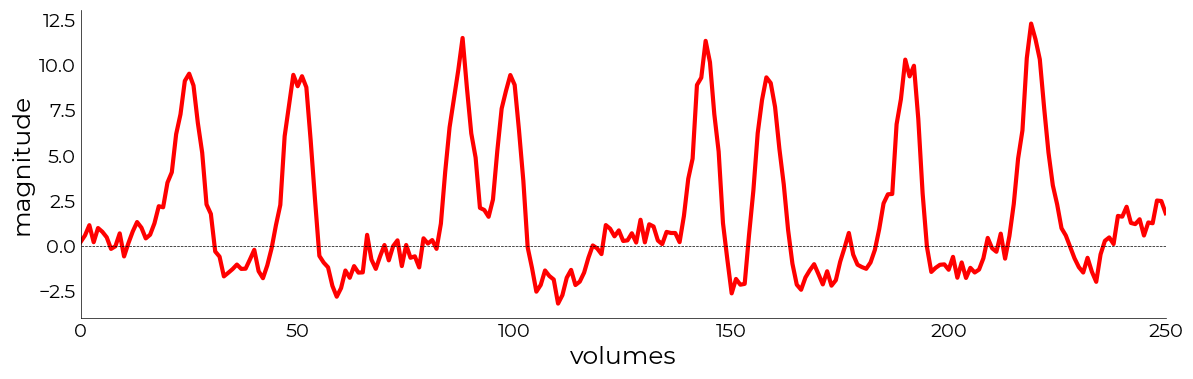

In [14]:
# plot example data
%matplotlib inline
plot_vert = prf_obj.max_r2_vert
tc = concat_data[plot_vert,:]
plotting.LazyPlot(
    tc,
    line_width=3,
    color="r",
    x_label="volumes",
    y_label="magnitude",
    add_hline=0
)

Reading design matrix from '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/design_task-2R.mat'
Reading data from '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/sub-997_ses-1_task-2R_hemi-LR_desc-avg_bold.npy'
Design has 4 more volumes than timecourses, trimming from beginning of design to (54, 54, 251)
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/code/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.32s
---------------------------------------------------------------------------------------------------

Instantiate HRF with: [1, 4.6, 0] (fit=True)
Using constraint(s): ['tc', 'tc']
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/sub-997_ses-1_task-2R_model-norm_stage-it

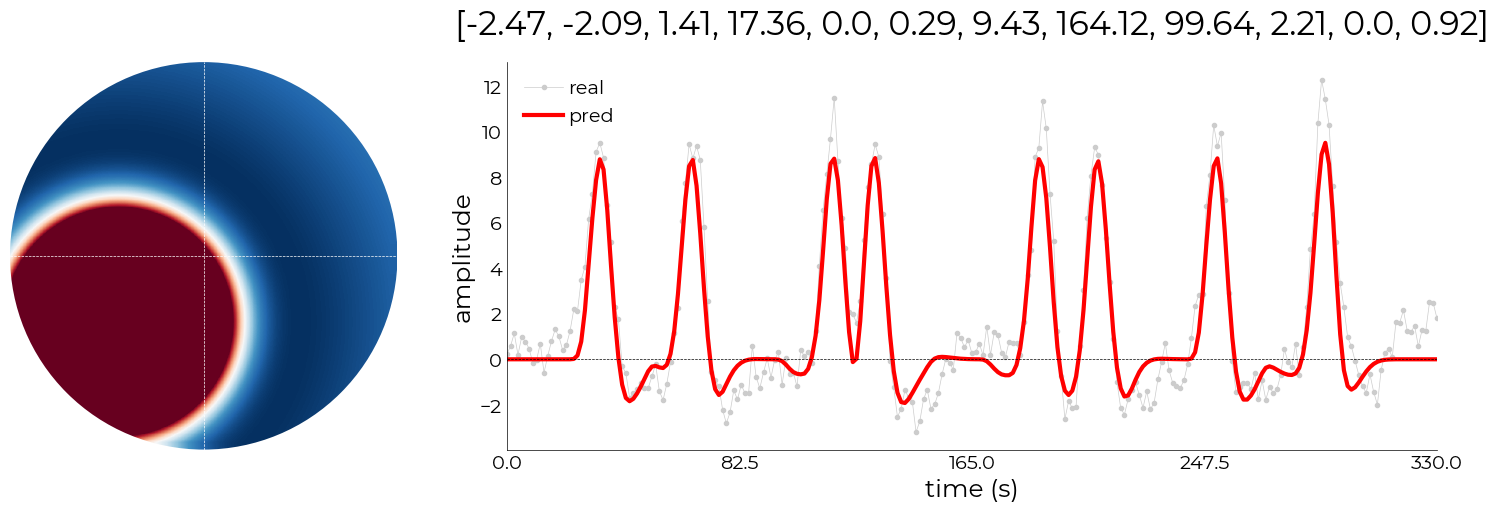

In [15]:
loader = prf.pRFmodelFitting(
    hemi_bold,
    design_matrix=dm_trg,
    TR=1.32,
    verbose=True,
    model="norm"
)

loader.load_params(model_files["norm"], model="norm")

# plot the example timecourse
_ = loader.plot_vox(vox_nr=plot_vert, model="norm", title="pars")

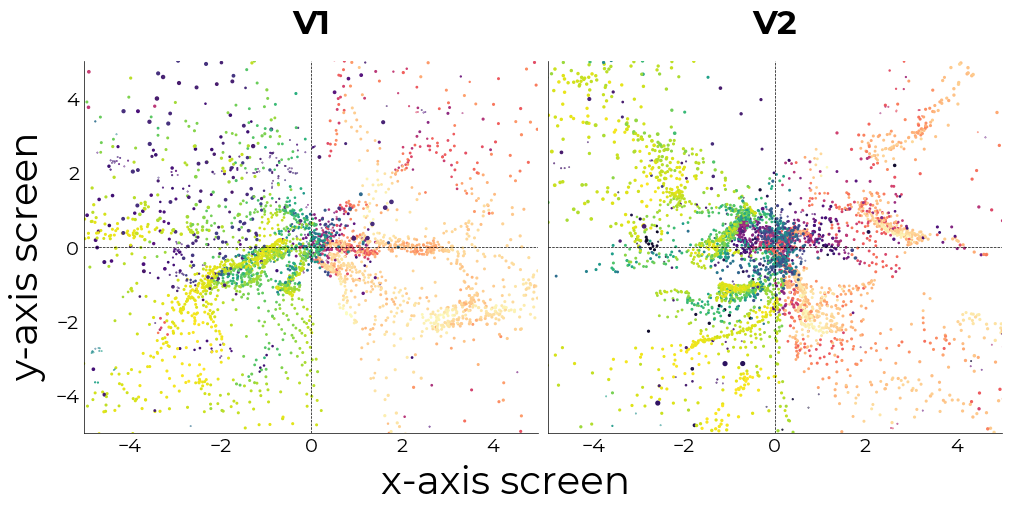

In [16]:
import matplotlib.pyplot as plt

fs_dir = os.path.dirname(fs_trg)

add_rois = ["V1_exvivo.thresh","V2_exvivo.thresh"]
add_tags = ["V1","V2"]

fig,axs = plt.subplots(ncols=len(add_rois), figsize=(len(add_rois)*5,5), constrained_layout=True, sharey=True, sharex=True)
n_verts = utils.get_vertex_nr(f"sub-{sub_jh}", fs_dir=fs_dir, as_list=True)
for roi_x,(roi,tag) in enumerate(zip(add_rois,add_tags)):
    
    label_file = optimal.SurfaceCalc.read_fs_label(fs_dir=fs_dir, subject=f"sub-{sub_jh}", fs_label=roi)
    cms = ["magma","viridis"]
    ax = axs[roi_x]
    for ix,(key,idx) in enumerate(label_file.items()):

        # add shape of left surface
        if key == "rh":
            idx += n_verts[0]

        ax.scatter(
            prf_obj.df_prf.x.iloc[idx].values,
            prf_obj.df_prf.y.iloc[idx].values,
            s=prf_obj.df_prf.prf_size.iloc[idx].values,
            c=prf_obj.df_prf.r2.iloc[idx].values,
            cmap=cms[ix]
        )

    plotting.conform_ax_to_obj(
        ax=ax, 
        add_hline={"pos": 0}, 
        add_vline={"pos": 0}, 
        x_lim=[-5,5], 
        y_lim=[-5,5],
        title={"title": tag, "fontweight": "bold"}
    )

fig.supylabel("y-axis screen", fontsize=28)
fig.supxlabel("x-axis screen", fontsize=28)
plt.show()

# Refit

- `--refit`: points script to `call_refit`
- `--bgfs`: faster optimizer, in this case fine because we don't want the fitter to go bezerk
- `-j <n_jobs`: use a bunch of cpus

In [21]:
cmd = f"master -m 17 -s {sub_jh} --norm -v 4 -r 1.32 --verbose --refit --skip_settings --bgfs -j 24"
print("Running following command:")
print(cmd)

Running following command:
master -m 17 -s 997 --norm -v 4 -r 1.32 --verbose --refit --skip_settings --bgfs -j 24


In [22]:
# actually execute it
if not os.path.exists(grid_file):
    os.system(cmd)
else:
    print(f"Grid-file exists; assuming refitting has been done already")

---------------------------------------------------------------------------------------------------
[17] pRF-fitting with pRFpy

pRF-FITTING WITH pRFpy
Started at Tue Jun 18 07:54:07 CEST 2024

**************************************** Processing sub-997 ***************************************
Running pRF-analysis; iter-fit with model norm
Dealing with task-ID: 2R
Using "/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/design_task-2R.mat" for design matrix
Refitting "/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/sub-997_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl"
Your job 245212 ("sub-997_ses-1_task-2R_model-norm") has been submitted

---------------------------------------------------------------------------------------------------
Done at Tue Jun 18 07:54:07 CEST 2024
Time spent: 0:00:00
---------------------------------------------------------------------------------------------------
[17] DON

# Verify

In [23]:
TR = 1.32

# initiate object
obj = prf.pRFmodelFitting(
    hemi_bold,
    # transpose=True,
    design_matrix=dm_trg,
    TR=TR,
    model="norm",
    verbose=True,
)

# load parameters
hemi_pars = opj(prf_dir, f"sub-{sub_jh}_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl")
obj.load_params(hemi_pars, model="norm", stage="iter") #, skip_settings=True)

Reading design matrix from '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/design_task-2R.mat'
Reading data from '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/sub-997_ses-1_task-2R_hemi-LR_desc-avg_bold.npy'
Design has 4 more volumes than timecourses, trimming from beginning of design to (54, 54, 251)
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/code/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.32s
---------------------------------------------------------------------------------------------------

Instantiate HRF with: [1, 4.6, 0] (fit=True)
Using constraint(s): ['tc', 'tc']
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/sub-997_ses-1_task-2R_model-norm_stage-it

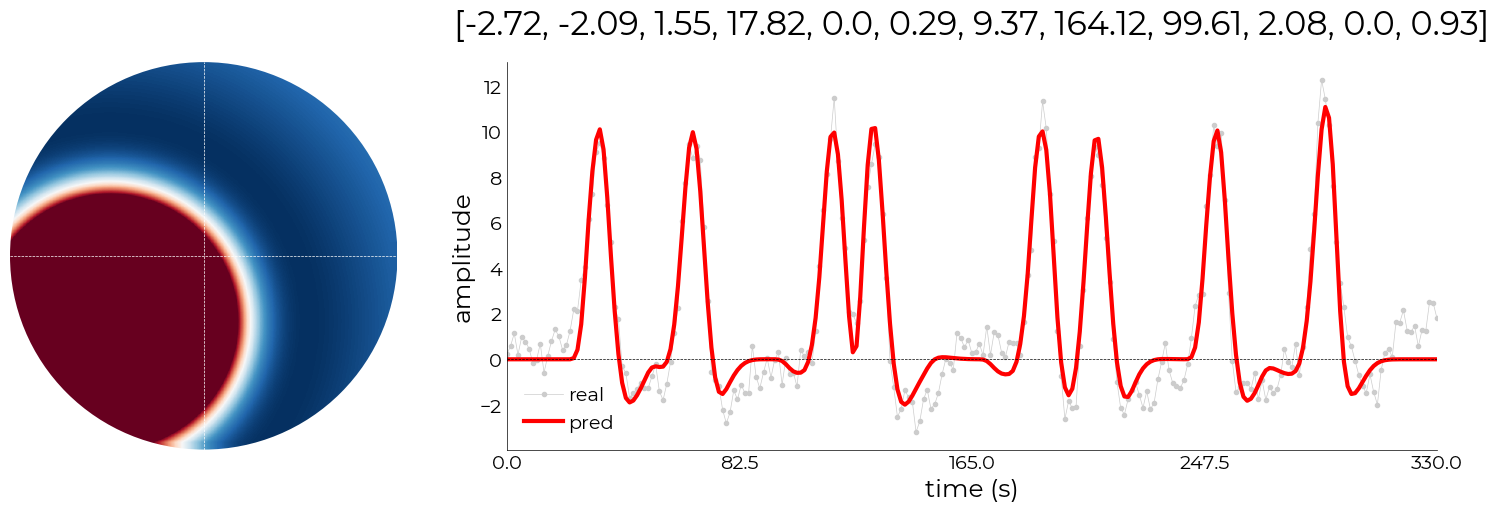

In [24]:
new_pars,_,_,_ = obj.plot_vox(vox_nr=plot_vert, model="norm", title="pars")

In [25]:
# TR = 1.5

# bold_old = '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-003/ses-1/sub-003_ses-1_task-2R_hemi-LR_desc-avg_bold.npy'
# # initiate object
# obj2 = prf.pRFmodelFitting(
#     bold_old,
#     # transpose=True,
#     design_matrix=opj(os.path.dirname(bold_old), "design_task-2R.mat"),
#     TR=TR,
#     model="norm",
#     verbose=True,
# )

# # load parameters
# hemi_pars = opj(os.path.dirname(bold_old), f"sub-003_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl")
# obj2.load_params(hemi_pars, model="norm", stage="iter") #, skip_settings=True)
# _ = obj2.plot_vox(vox_nr=835, model="norm", title="pars")

## Copy to VE-SRF

In [26]:
# FreeSurfer
fs_src = opj(jh_proj, "derivatives", "freesurfer", f"sub-{sub_jh}")
fs_trg = opj(ve_proj, "derivatives", "freesurfer", f"sub-{sub_ve}")

if not os.path.exists(fs_trg):
    print(f"Copying '{fs_src}' to '{fs_trg}'")
    shutil.copytree(fs_src, fs_trg)
    print("Done")
else:
    print(f"freesurfer exists: {os.path.exists(fs_trg)}")

Copying '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/freesurfer/sub-997' to '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/freesurfer/sub-015'
Done


In [27]:
# fmriprep
fprep_src = opj(jh_proj, "derivatives", "fmriprep", f"sub-{sub_jh}", f"ses-{ses_jh}")
fprep_trg = opj(ve_proj, "derivatives", "fmriprep", f"sub-{sub_ve}", f"ses-1")

if not os.path.exists(fprep_trg):
    os.makedirs(fprep_trg, exist_ok=True)

# decide execution rules
execute = False
if not os.path.exists(fprep_trg):
    execute = True
else:
    if len(os.listdir(fprep_trg)) == 0:
        shutil.rmtree(fprep_trg)
        execute = True

if execute:
    print(f"Copying '{fprep_src}' to '{fprep_trg}'")
    shutil.copytree(fprep_src, fprep_trg)
    print("Done")
else:
    print(f"fmriprep exists: {os.path.exists(opj(fprep_trg, 'func'))}")

# rename subIDs
remaining_files = utils.get_file_from_substring([], opj(fprep_trg, "func"))

for src in remaining_files:
    if f"sub-{sub_jh}" in src:
        trg = utils.replace_string(src, f"sub-{sub_jh}", f"sub-{sub_ve}")
        os.rename(src,trg)
utils.get_file_from_substring(["run-1"], opj(fprep_trg, "func"))

Copying '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/fmriprep/sub-997/ses-1' to '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/fmriprep/sub-015/ses-1'
Done


['/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-2_task-2R_acq-3DEPI_run-1_boldref.nii.gz',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-2_task-2R_acq-3DEPI_run-1_desc-brain_mask.json',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-2_task-2R_acq-3DEPI_run-1_desc-brain_mask.nii.gz',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-2_task-2R_acq-3DEPI_run-1_desc-confounds_timeseries.json',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-2_task-2R_acq-3DEPI_run-1_desc-confounds_timeseries.tsv',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-2_task-2R_acq-3DEPI_run-1_desc-preproc_bold.json',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/fmriprep

In [28]:
# prf
prf_src = opj(jh_proj, "derivatives", "prf", f"sub-{sub_jh}", f"ses-{ses_jh}")
prf_trg = opj(ve_proj, "derivatives", "prf", f"sub-{sub_ve}", f"ses-1")

# make dirname
if not os.path.exists(os.path.dirname(prf_trg)):
    os.makedirs(os.path.dirname(prf_trg), exist_ok=True)

# copy session
if not os.path.exists(prf_trg):
    print(f"Copying '{prf_src}' to '{prf_trg}'")
    shutil.copytree(prf_src, prf_trg)
    print("Done")

# rename subIDs
remaining_files = utils.get_file_from_substring([], prf_trg)

for src in remaining_files:
    if f"sub-{sub_jh}" in src:
        trg = utils.replace_string(src, f"sub-{sub_jh}", f"sub-{sub_ve}")
        os.rename(src,trg)
utils.get_file_from_substring([], prf_trg)

Copying '/data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1' to '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-015/ses-1'
Done


['/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-015/ses-1/design_task-2R.mat',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_desc-command.txt',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_hemi-LR_desc-avg_bold.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_model-gauss_stage-iter_desc-prf_params.pkl',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_model-norm.o245212',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_model-norm_stage-grid_desc-prf_params.pkl',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl']

## Run size-response

In [29]:
split_file = os.path.basename(model_files["norm"]).split("_")
desc_idx = split_file.index("desc-prf")
base_name = "_".join(split_file[:desc_idx])+"_desc-srfs_centered"
 
cmd = f"qsub -N {base_name} -wd {os.path.dirname(model_files['norm'])} -q long.q {opj(os.environ.get('DIR_SCRIPTS'), 'bin', 'call_sizeresponse')} --in {model_files['norm']} --verbose"
print(cmd)
os.system(cmd)

qsub -N sub-997_ses-1_task-2R_model-norm_stage-iter_desc-srfs_centered -wd /data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1 -q long.q /data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/bin/call_sizeresponse --in /data1/projects/MicroFunc/Jurjen/projects/PotentialSubjs/derivatives/prf/sub-997/ses-1/sub-997_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl --verbose
Your job 245213 ("sub-997_ses-1_task-2R_model-norm_stage-iter_desc-srfs_centered") has been submitted


0

In [77]:
%matplotlib inline
# read the coordinate file
info_file = opj(
    ve_proj,
    "derivatives",
    "pycortex",
    f"sub-{sub_ve}",
    f"ses-{ses_ve}",
    f"sub-{sub_ve}_ses-{ses_ve}_desc-coords.csv"
)

if not os.path.exists(info_file):
    raise FileNotFoundError(f"Could not find file '{info_file}'. Please run: 'master -m 18 -s {sub_ve} -l {ses_ve} --norm --no_srf --manual --skip_prf_info'")

targ_info = utils.VertexInfo(info_file)

# Size response function

In [67]:
model_file = opj(
    ve_proj,
    "derivatives",
    "pycortex",
    f"sub-{sub_ve}",
    f"ses-{ses_ve}",
    f"sub-{sub_ve}_ses-{ses_ve}_model-norm_desc-best_vertices.csv"
)

df = pd.read_csv(model_file)
df

,x,y,prf_size,prf_ampl,bold_bsl,surr_ampl,surr_size,neur_bsl,surr_bsl,A,...,size ratio,suppression index,ecc,polar,hrf_deriv,hrf_dsip,index,position,normal,hemi
0,1.211419,-0.537300,0.885286,40.394284,0.0,1.446913,12.003640,40.401638,99.997017,40.394284,...,13.559046,6.585380,1.325227,-0.417460,2.120237,0.0,2253,[-20.48599 -83.99397 -23.849026],[-0.55022474 -0.79340867 0.26029871],L
1,-0.754267,-0.328146,0.924915,75.101313,0.0,1.201808,13.251787,75.847447,97.087612,75.101313,...,14.327575,3.284981,0.822556,-2.731238,0.332876,0.0,162507,[ 9.653781 -82.31732 -20.95518 ],[-0.3996194 0.8779105 0.26377547],R


Hemisphere: L
 Max stimulation @2.39dva | ampl = 10.92
 Min stimulation @7.18dva | ampl = -0.4
Hemisphere: R
 Max stimulation @2.52dva | ampl = 23.85
 Min stimulation @7.55dva | ampl = -0.76


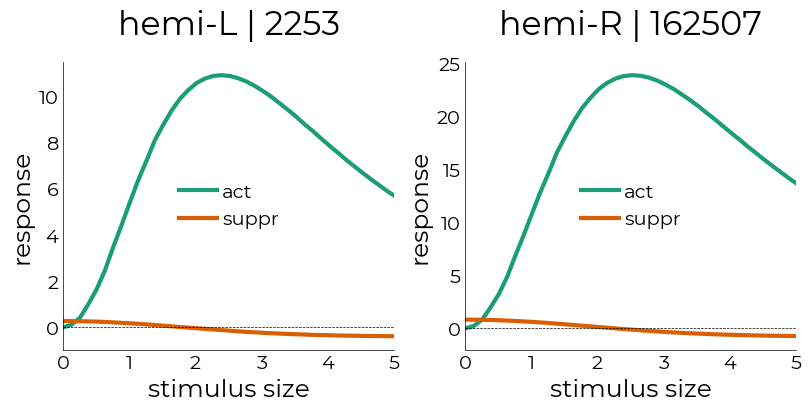

In [68]:
sizes = []
betas = []

fig,axs = plt.subplots(ncols=2, figsize=(8,4), constrained_layout=True)
for ix,hemi in enumerate(["L","R"]):

    print(f"Hemisphere: {hemi}")
    targ_vert = targ_info.get("index", hemi=hemi)
    n_verts = utils.get_vertex_nr("sub-994", fs_dir=opj(jh_proj, "derivatives", "freesurfer"), as_list=True)
    if hemi == "R":
        targ_vert += n_verts[0]

    # plot the model fit
    start_pars,_,tc_targ,pred_targ = obj.plot_vox(vox_nr=targ_vert, make_figure=False, model="norm")

    # calculate sizeresponse
    SR_ = prf.SizeResponse(params=start_pars, model="norm")

    ## CENTERED PRF

    # size response
    fill_cent, fill_cent_sizes = SR_.make_stimuli(
        factor=1,
        dt="fill"
    )

    sr_cent_act = SR_.batch_sr_function(
        SR_.params_df,
        center_prf=True,
        stims=fill_cent,
        sizes=fill_cent_sizes
    )

    # hole-response
    hole_cent, hole_cent_sizes = SR_.make_stimuli(
        factor=1,
        dt="hole"
    )

    sr_cent_norm = SR_.batch_sr_function(
        SR_.params_df,
        center_prf=True,
        stims=hole_cent,
        sizes=hole_cent_sizes
    )

    %matplotlib inline
    ## PLOT
    plotting.LazyPlot(
        [df.iloc[:,0].values for df in [sr_cent_act,sr_cent_norm]],
        xx=fill_cent_sizes,
        color=["#1B9E77","#D95F02"],
        line_width=3,
        axs=axs[ix],
        x_label="stimulus size",
        y_label="response",
        labels=["act","suppr"],
        add_hline=0,
        title=f"hemi-{hemi} | {targ_vert}",
        x_lim=[0,5]
    )

    max_dva, max_val = SR_.find_stim_sizes(
        sr_cent_act[0].values,
        t="max",
        dt="fill",
        sizes=fill_cent_sizes,
        return_ampl=True
    )
    print(f" Max stimulation @{round(max_dva,2)}dva | ampl = {round(max_val,2)}")

    min_dva, min_val = SR_.find_stim_sizes(
        sr_cent_norm[0].values,
        t="min",
        dt="fill",
        sizes=fill_cent_sizes,
        return_ampl=True
    )
    print(f" Min stimulation @{round(min_dva,2)}dva | ampl = {round(min_val,2)}")

    sizes.append(np.array([max_dva,min_dva]))
    betas.append(np.array([max_val,min_val]))

In [71]:
df["stim_sizes"] = sizes
df["stim_betas"] = betas
df

,x,y,prf_size,prf_ampl,bold_bsl,surr_ampl,surr_size,neur_bsl,surr_bsl,A,...,ecc,polar,hrf_deriv,hrf_dsip,index,position,normal,hemi,stim_sizes,stim_betas
0,1.211419,-0.537300,0.885286,40.394284,0.0,1.446913,12.003640,40.401638,99.997017,40.394284,...,1.325227,-0.417460,2.120237,0.0,2253,[-20.48599 -83.99397 -23.849026],[-0.55022474 -0.79340867 0.26029871],L,"[2.3920789839300047, 7.176236951790014]","[10.91651809757779, -0.39674653109307084]"
1,-0.754267,-0.328146,0.924915,75.101313,0.0,1.201808,13.251787,75.847447,97.087612,75.101313,...,0.822556,-2.731238,0.332876,0.0,162507,[ 9.653781 -82.31732 -20.95518 ],[-0.3996194 0.8779105 0.26377547],R,"[2.5179778778210573, 7.5539336334631715]","[23.846700615480483, -0.7649402151054058]"


## Copy to spinoza_pRF

### FreeSurfer

In [10]:
sub_jh = "012"
sub_sc = "015"

# FreeSurfer
fs_src = opj(ve_proj, "derivatives", "freesurfer", f"sub-{sub_jh}")
fs_trg = opj(sc_proj, "derivatives", "freesurfer", f"sub-{sub_sc}")

if not os.path.exists(fs_trg):
    print(f"Copying '{fs_src}' to '{fs_trg}'")
    shutil.copytree(fs_src, fs_trg)
    print("Done")
else:
    print(f"freesurfer exists: {os.path.exists(fs_trg)}")

Copying '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/freesurfer/sub-012' to '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/freesurfer/sub-015'
Done


### fmriprep

In [11]:
# fmriprep
fprep_trg = opj(sc_proj, "derivatives", "fmriprep", f"sub-{sub_sc}", f"ses-1")
fprep_src = opj(ve_proj, "derivatives", "fmriprep", f"sub-{sub_ve}", f"ses-1")

if not os.path.exists(fprep_trg):
    os.makedirs(fprep_trg, exist_ok=True)

# decide execution rules
execute = False
if not os.path.exists(fprep_trg):
    execute = True
else:
    if len(os.listdir(fprep_trg)) == 0:
        shutil.rmtree(fprep_trg)
        execute = True

if execute:
    print(f"Copying '{fprep_src}' to '{fprep_trg}'")
    shutil.copytree(fprep_src, fprep_trg)
    print("Done")
else:
    print(f"fmriprep exists: {os.path.exists(opj(fprep_trg, 'func'))}")

# rename subIDs
remaining_files = utils.get_file_from_substring([], opj(fprep_trg, "func"))

for src in remaining_files:
    if f"sub-{sub_ve}" in src:
        trg = utils.replace_string(src, f"sub-{sub_ve}", f"sub-{sub_sc}")
        os.rename(src,trg)
utils.get_file_from_substring(["run-1"], opj(fprep_trg, "func"))

Copying '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/fmriprep/sub-011/ses-1' to '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/fmriprep/sub-015/ses-1'


Done


['/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-1_task-2R_acq-3DEPI_run-1_boldref.nii.gz',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-1_task-2R_acq-3DEPI_run-1_desc-brain_mask.json',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-1_task-2R_acq-3DEPI_run-1_desc-brain_mask.nii.gz',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-1_task-2R_acq-3DEPI_run-1_desc-confounds_timeseries.json',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-1_task-2R_acq-3DEPI_run-1_desc-confounds_timeseries.tsv',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/fmriprep/sub-015/ses-1/func/sub-015_ses-1_task-2R_acq-3DEPI_run-1_desc-preproc_bold.json',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/fmriprep

### pRF

In [12]:
# prf
prf_trg = opj(sc_proj, "derivatives", "prf", f"sub-{sub_sc}", f"ses-1")
prf_src = opj(ve_proj, "derivatives", "prf", f"sub-{sub_ve}", f"ses-1")

# make dirname
if not os.path.exists(os.path.dirname(prf_trg)):
    os.makedirs(os.path.dirname(prf_trg), exist_ok=True)

# copy session
if not os.path.exists(prf_trg):
    print(f"Copying '{prf_src}' to '{prf_trg}'")
    shutil.copytree(prf_src, prf_trg)
    print("Done")

# rename subIDs
remaining_files = utils.get_file_from_substring([], prf_trg)

for src in remaining_files:
    if f"sub-{sub_ve}" in src:
        trg = utils.replace_string(src, f"sub-{sub_ve}", f"sub-{sub_sc}")
        os.rename(src,trg)
utils.get_file_from_substring([], prf_trg)

Copying '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-011/ses-1' to '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/prf/sub-015/ses-1'
Done


['/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/prf/sub-015/ses-1/design_task-2R.mat',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_desc-command.txt',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_hemi-LR_desc-avg_bold.npy',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_hemi-L_desc-avg_bold.npy',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_hemi-L_vox-3124_model-norm_stage-iter.svg',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_hemi-R_desc-avg_bold.npy',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/prf/sub-015/ses-1/sub-015_ses-1_task-2R_hemi-R_vox-167487_model-norm_stage-iter.svg',
 '/data1/projects/dumoulinlab/Projects/spinoza_pRF/derivatives/prf/sub-015/ses-1/sub-015_